## Building Predictive Models for a Targeted Marketing Campaign
A subset of data from a targeted marketing campaign will be used for this project. The original data have hundreds of fields and hundreds of thousands of records; some other changes have been made as well. Each data record describes a targeted consumer by various attributes.

In [128]:
import json 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from scikitplot.helpers import cumulative_gain_curve

%matplotlib inline

### Getting the data

In [134]:
# Getting data as a list
with open("assess2_data.json") as f:
    data = json.load(f)

# Getting attributes 
keys = data[0].keys()
print("Attributes are: \n", keys, sep='\n')

# Dropping rows with -9999 (missing values) 
for index, record  in enumerate(data):
    if "-9999" in str(record):
        print('\nDropping record... ', record, sep='\n\n')
        data.pop(index)

# Creating a Pandas dataframe
df = pd.DataFrame(data=data, columns=keys)
print('\nHead of data: \n', df.head())

print("\nNumber of customers: ", len(df))

Attributes are: 

dict_keys(['PEPSTRFL', 'FISTDATE', 'NAME', 'WEALTH_INDEX', 'AVGGIFT', 'LASTDATE', 'INCOME', 'RFA_2F', 'TARGET_B', 'LASTGIFT', 'RFA_2A'])

Dropping record... 

{'PEPSTRFL': 'X', 'FISTDATE': -9999, 'NAME': "Tyler O'Bathe", 'WEALTH_INDEX': 7.97, 'AVGGIFT': 9.2105263158, 'LASTDATE': -9999, 'INCOME': 1, 'RFA_2F': 3, 'TARGET_B': 0, 'LASTGIFT': 20, 'RFA_2A': 'F'}

Dropping record... 

{'PEPSTRFL': 'X', 'FISTDATE': 9109, 'NAME': 'Smriti F. Doban', 'WEALTH_INDEX': 3.63, 'AVGGIFT': -9999, 'LASTDATE': 9507, 'INCOME': 2, 'RFA_2F': 3, 'TARGET_B': 0, 'LASTGIFT': 11, 'RFA_2A': 'E'}

Dropping record... 

{'PEPSTRFL': 'X', 'FISTDATE': 9402, 'NAME': 'Vitalii Z. George Sr.', 'WEALTH_INDEX': 23.44, 'AVGGIFT': 16, 'LASTDATE': 9509, 'INCOME': 4, 'RFA_2F': 1, 'TARGET_B': 0, 'LASTGIFT': 40, 'RFA_2A': '-9999'}

Head of data: 
   PEPSTRFL  FISTDATE                  NAME  WEALTH_INDEX    AVGGIFT  LASTDATE  \
0        X      9001       Reshama Y. Saat          3.33   7.481481      9512   
1     

### Identifying the types of variables in data
- RFA_2F and RFA_2A are marketing codes summarizing the recency and frequency of historical customer response
- WEALTH_INDEX takes numerical values from 0.01 to 99.85
- TARGET_B describes whether this customer responded ( 1 ) or did not respond ( 0 ) to the campaign

In [82]:
print("RFA_2A categories counts:", df['RFA_2A'].value_counts(), sep='\n')
print('\n')
print("RFA_2F categories counts:", df['RFA_2F'].value_counts(), sep='\n')
print('\n')
print("Max wealth_index:", df.WEALTH_INDEX.max(), sep='\n')
print('\n')
print("Min wealth_index:", df.WEALTH_INDEX.min(), sep='\n')
print('\n')
print("Target Values:", df.TARGET_B.value_counts(), sep='\n')
print('\n')
proportion = df.TARGET_B.value_counts()[1]/df.TARGET_B.value_counts()[0]
print("Response Proportion: {:1.2f}%".format(proportion*100), sep= '\n')

RFA_2A categories counts:
E    12884
F    12189
G     5125
D     5074
Name: RFA_2A, dtype: int64


RFA_2F categories counts:
1    12530
2     8134
3     7367
4     7241
Name: RFA_2F, dtype: int64


Max wealth_index:
99.85


Min wealth_index:
0.01


Target Values:
0    33046
1     2226
Name: TARGET_B, dtype: int64


Response Proportion: 6.74%


#### Plotting the distributions of WEALTH_INDEX for the responders and non-responders

Text(0.5,1,'Normalized Histogram of Wealth Index')

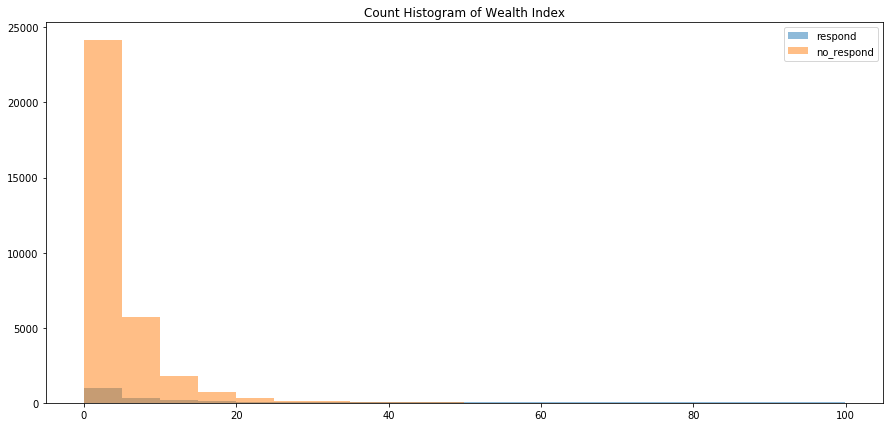

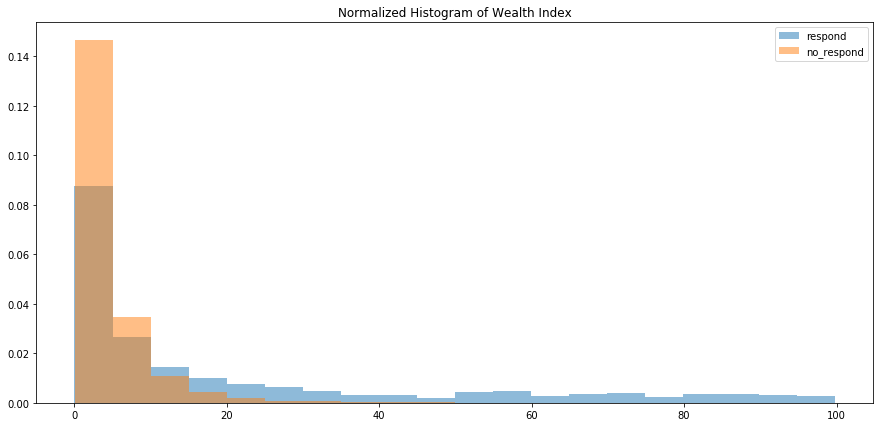

In [79]:
respond = df['TARGET_B']==1
no_respond = df['TARGET_B']==0
plt.figure(figsize=(15,7))
plt.hist(df[respond]['WEALTH_INDEX'], bins=20, alpha=0.5, label='respond')
plt.hist(df[no_respond]['WEALTH_INDEX'], bins=20, alpha=0.5, label='no_respond')
plt.legend()
plt.title("Count Histogram of Wealth Index")

plt.figure(figsize=(15,7))
plt.hist(df[respond]['WEALTH_INDEX'], bins=20, alpha=0.5, label='respond', density=True)
plt.hist(df[no_respond]['WEALTH_INDEX'], bins=20, alpha=0.5, label='no_respond', density=True)
plt.legend()
plt.title("Normalized Histogram of Wealth Index")

### Clustering
- Estimate the number of clusters in the data. We will try Elbow analysis and a Dendrogram
- To use k-means clustering we need to have numerical data as euclidean distance is not defined for categorical data
- We also drop the target as we are using an unsupervised algorithm

In [71]:
df_num = df.drop(['NAME', 'PEPSTRFL', 'RFA_2A', 'RFA_2F', 'TARGET_B'], axis=1)

# Normalizing the data using minmax method to limit all values to [0,1]
min_max_scaler = MinMaxScaler()
df_num_norm = min_max_scaler.fit_transform(df_num)

# A random sample of data is drawn to create the dendrogram 
sample_size = 2000
random_index = np.random.randint(0, len(df_num_norm), sample_size)
df_num_norm_sample = df_num_norm[random_index]

/home/omid/anaconda2/envs/python3/lib/python3.5/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


<IPython.core.display.Javascript object>


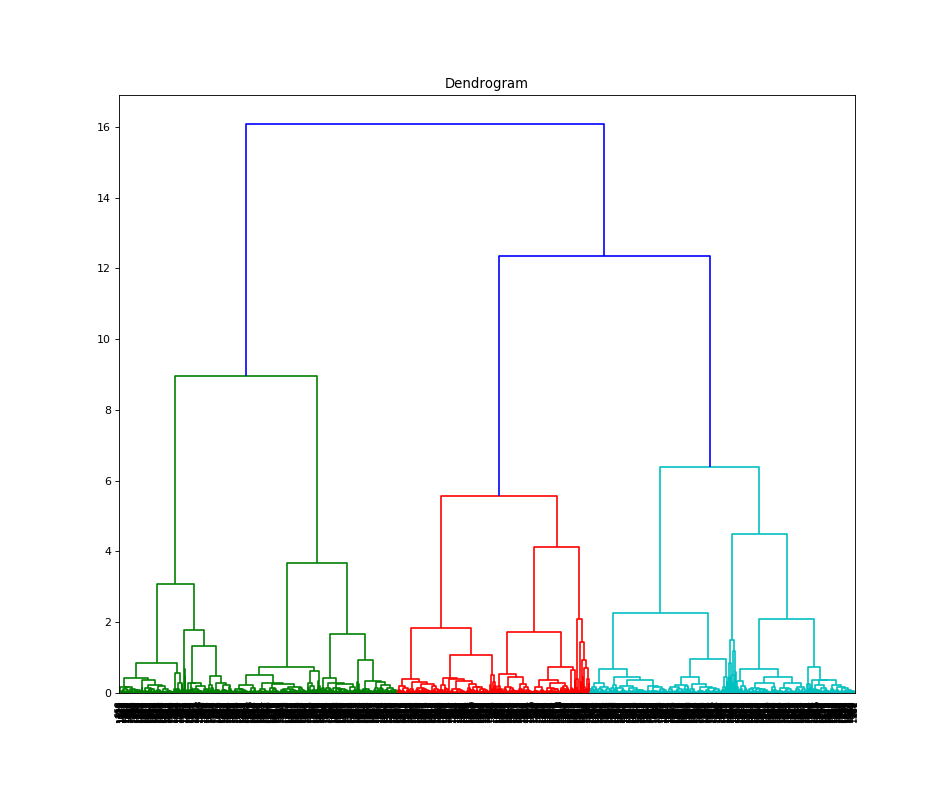

Text(0.5,1,'Dendrogram')

In [127]:
# Dendrogram:
Z = linkage(df_num_norm_sample, method='ward', metric='euclidean')
plt.figure(figsize=(12,10))
dendrogram(Z, leaf_rotation=90, leaf_font_size=8) 
plt.title("Dendrogram")

<IPython.core.display.Javascript object>


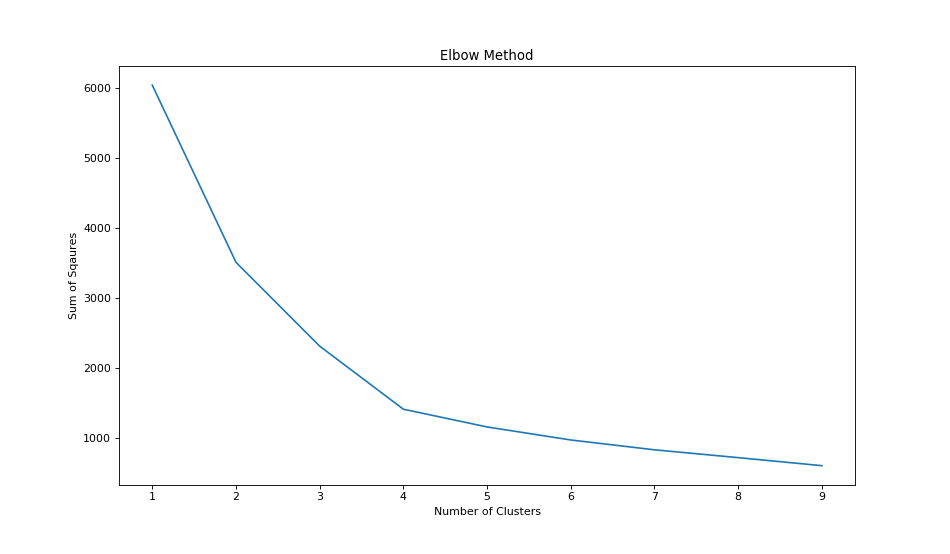

Text(0,0.5,'Sum of Sqaures')

In [125]:
# Elbow method
inertia_list = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_num_norm)
    inertia_list.append(kmeans.inertia_)
plt.figure(figsize=(12,7))
plt.plot(range(1,10), inertia_list)
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Sqaures")

### Preparing the data

In [135]:
# Creating dummy codes for categorical variables, and dropping the first category (to avoid redundant data)

df.drop(['PEPSTRFL', 'NAME'], axis=1, inplace=True)

rfa_2f = pd.get_dummies(df['RFA_2F'], prefix='RFA_2F_', drop_first=True)
rfa_2a = pd.get_dummies(df['RFA_2A'], prefix='RFA_2A_', drop_first=True)
income = pd.get_dummies(df['INCOME'], prefix='INCOME_', drop_first=True)
df = pd.concat([df,rfa_2f, rfa_2a, income], axis=1)

# Dropping the original variables 
df.drop(['RFA_2F', 'RFA_2A', 'INCOME'], axis=1, inplace=True)

# Creating the X and y variables 
X = df.drop('TARGET_B', axis=1)
y = df['TARGET_B']

# Splitting the data into train and test
X_train, X_test, y_train, y_test=train_test_split(X, y,test_size=0.1)

In [131]:
X_train.columns

Index(['FISTDATE', 'WEALTH_INDEX', 'AVGGIFT', 'LASTDATE', 'LASTGIFT',
       'RFA_2F__2', 'RFA_2F__3', 'RFA_2F__4', 'RFA_2A__E', 'RFA_2A__F',
       'RFA_2A__G', 'INCOME__2', 'INCOME__3', 'INCOME__4', 'INCOME__5',
       'INCOME__6', 'INCOME__7'],
      dtype='object')

In [51]:
# Dictionaries to store the ROC rate values and predictions for each classifier
roc_dict = {}
pred_dict = {}

### Logistic Regression

In [56]:
# Logistic Regression
logregmodel = LogisticRegression(solver='lbfgs')
logregmodel.fit(X_train, y_train)

predictions = logregmodel.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, predictions[:,1])
print("Logistic model AUC (Training set): {:1.2f}".format(auc(fpr, tpr)))

predictions = logregmodel.predict_proba(X_test)
pred_dict['Log-reg'] = predictions
fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])
roc_dict['log-reg'] = [fpr, tpr, thresholds]
print("Logistic model AUC (Test set): {:1.2f}".format(auc(fpr, tpr)))

Logistic model AUC (Training set): 0.70
Logistic model AUC (Test set): 0.69


### Decision Tree

In [57]:
## Decision Tree
dtreemodel = DecisionTreeClassifier()
dtreemodel.fit(X_train, y_train)

predictions = dtreemodel.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, predictions[:,1])
print("Decision Tree model AUC (Training set): {:1.2f}".format(auc(fpr, tpr)))

predictions = dtreemodel.predict_proba(X_test)
pred_dict['D-tree'] = predictions
fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])
roc_dict['D-tree'] = [fpr, tpr, thresholds]
print("Decision Tree model AUC (Test set): {:1.2f}".format(auc(fpr, tpr)))

Decision Tree model AUC (Training set): 1.00
Decision Tree model AUC (Test set): 0.59


The Decision Tree classifier has perfect performance on the train data but performs poorly on the test set. So, the problem is overfitting (low bias, high variance). To avoid this issue we will use a Random Forest classifier.

### Random Forest
A random forest model with 100 trees and all default parameters will be trained

In [58]:
## Random Forest

rforestmodel = RandomForestClassifier(n_estimators=100)
rforestmodel.fit(X_train, y_train)

predictions = rforestmodel.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, predictions[:,1])
print("Random Forest model AUC (Training set): {:1.2f}".format(auc(fpr, tpr)))

predictions = rforestmodel.predict_proba(X_test)
pred_dict['Random-f'] = predictions
fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])
roc_dict['Random-f'] = [fpr, tpr, thresholds]
print("Random Forest model AUC (Test set): {:1.2f}".format(auc(fpr, tpr)))

Random Forest model AUC (Training set): 1.00
Random Forest model AUC (Test set): 0.73


### Tuned Random Forest
The previous model will now be tuned using grid search on the number of trees, max depth and max number of features 

In [136]:
# Tuned Random Forest with grid search

param_grid = {'n_estimators':[100, 200, 500], 'max_features':['auto', 6, 12], 
              'max_depth': [15, 20, 25]}
RFgrid = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, verbose=1, n_jobs=-1)
RFgrid.fit(X_train, y_train)

print("Best params for rf: ", RFgrid.best_params_)
print("Best rf estimator", RFgrid.best_estimator_)

predictions = RFgrid.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, predictions[:,1])
print("Optimized Random Forest model AUC (Training set): {:1.2f}".format(auc(fpr, tpr)))

predictions = RFgrid.predict_proba(X_test)
pred_dict['Tuned-rf'] = predictions
fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])
roc_dict['Tuned-rf'] = [fpr, tpr, thresholds]
print("Optimized Random Forest model AUC (Test set): {:1.2f}".format(auc(fpr, tpr)))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  5.3min finished


Best params for rf:  {'n_estimators': 200, 'max_features': 6, 'max_depth': 20}
Best rf estimator RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=6, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Optimized Random Forest model AUC (Training set): 1.00
Optimized Random Forest model AUC (Test set): 0.78


**After tuning the random forest we were able to improve the AUC metric by 5%**

### Naive Bayes

In [60]:
nbayesmodel = GaussianNB()
nbayesmodel.fit(X_train, y_train)

predictions = nbayesmodel.predict_proba(X_train)
fpr, tpr, thresholds = roc_curve(y_train, predictions[:,1])
print("Naive Bayes model AUC (Training set): {:1.2f}".format(auc(fpr, tpr)))

predictions = nbayesmodel.predict_proba(X_test)
pred_dict['Naive-b'] = predictions
fpr, tpr, thresholds = roc_curve(y_test, predictions[:,1])
roc_dict['Naive-b'] = [fpr, tpr, thresholds]
print("Naive Bayes model AUC (Test set): {:1.2f}".format(auc(fpr, tpr)))

Naive Bayes model AUC (Training set): 0.73
Naive Bayes model AUC (Test set): 0.71


#### Random Forest classifier with 200 trees, max depth of 20 and max number of features of 6 achieves the best performance among the trained classifiers.

**Classification Report**

In [139]:
predictions = np.argsort(pred_dict['Tuned-rf'])[:,1]
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.95      1.00      0.97      3315
           1       0.79      0.26      0.39       213

   micro avg       0.95      0.95      0.95      3528
   macro avg       0.87      0.63      0.68      3528
weighted avg       0.94      0.95      0.94      3528



**Confusion Matrix**

In [141]:
print(confusion_matrix(y_test, predictions))

[[3300   15]
 [ 157   56]]


In [137]:
# calculating the accuracy for the optimized random forest model on the test set:
print("Random Forest Accuracy: {:2.2f}%".format( 
      np.sum(np.argsort(pred_dict['Tuned-rf'])[:,1] == y_test)/len(y_test)*100))

Random Forest Accuracy: 95.12%


### Plotting the ROC curves

<IPython.core.display.Javascript object>


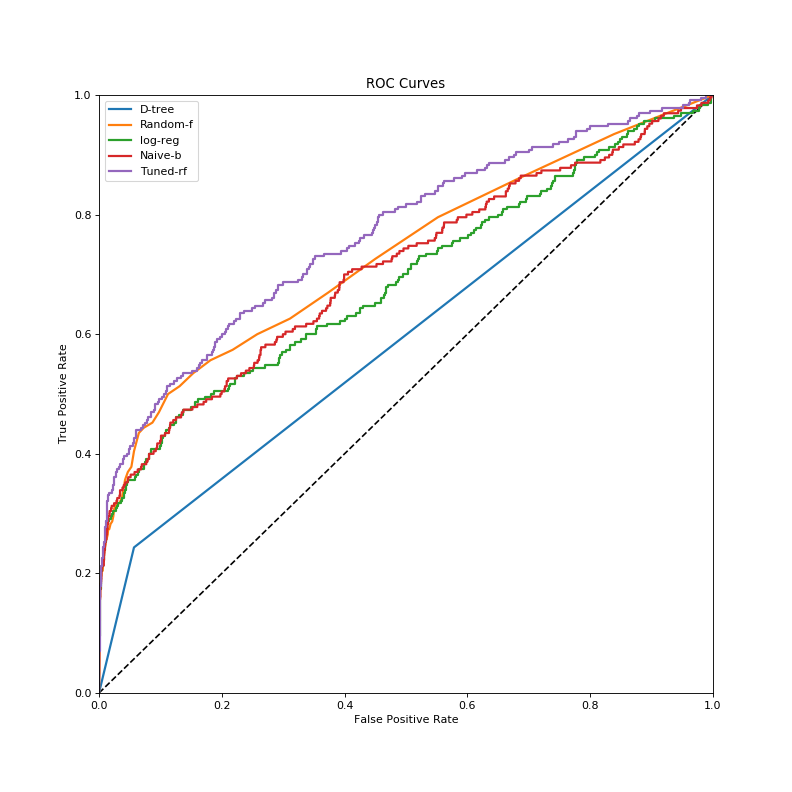

In [124]:
%matplotlib notebook
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curves")
for key in roc_dict:
    plt.plot(roc_dict[key][0], roc_dict[key][1], linewidth=2, label=str(key))
plt.legend()

### Cumulative Response cuves
#### Cumulative response curves are useful as they show the relative performance of models depending on the percentage of instances we are interested in targetting

<IPython.core.display.Javascript object>


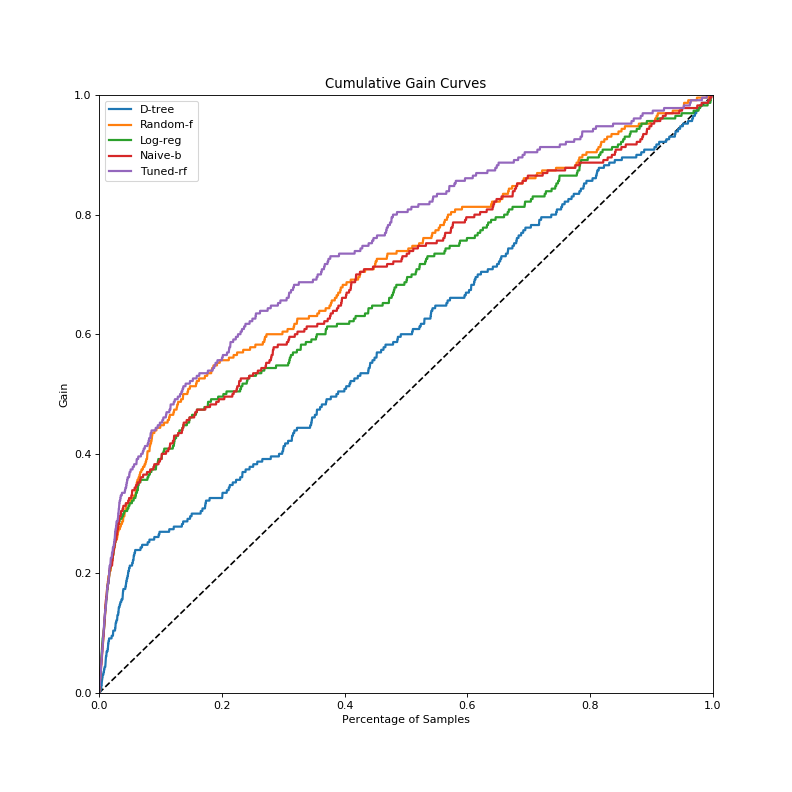

In [123]:
%matplotlib notebook
plt.figure(figsize=(10,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.title("Cumulative Gain Curves")
plt.xlabel('Percentage of Samples')
plt.ylabel('Gain')
for key in pred_dict:
    percentages, gains = cumulative_gain_curve(y_test, pred_dict[key][:,1])
    plt.plot(percentages, gains, linewidth=2, label=str(key))
plt.legend()

**Using the cumulative gain curves we can choose the best classifier if we had a budget to target only specific percentage of customers.**

### Lift Curves 

<IPython.core.display.Javascript object>


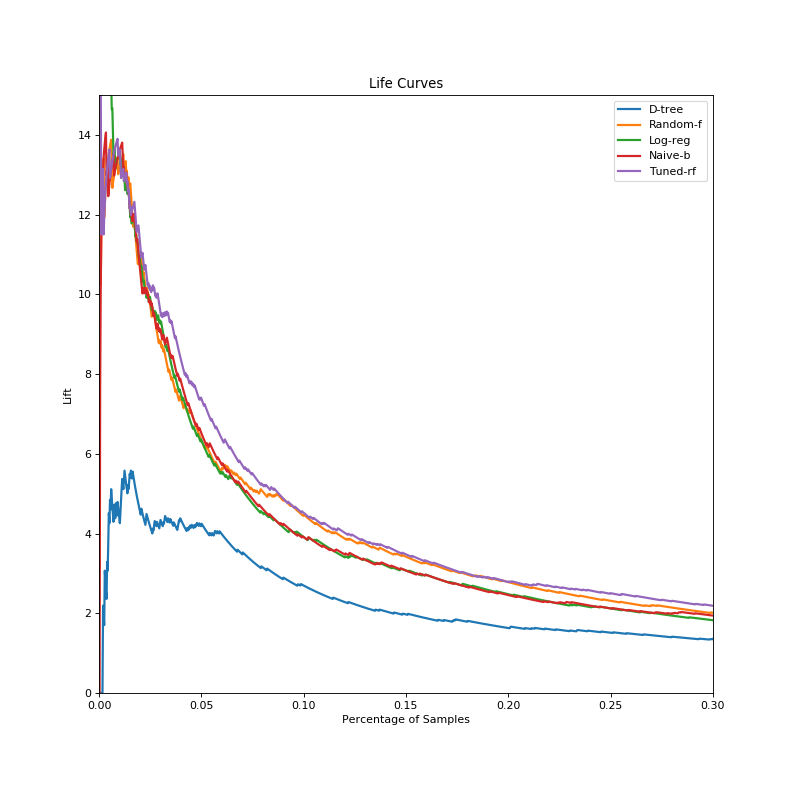

In [122]:
%matplotlib notebook
plt.figure(figsize=(10,10))
#plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 0.3, 0, 15])
plt.title("Life Curves")
plt.xlabel('Percentage of Samples')
plt.ylabel('Lift')
for key in pred_dict:
    percentages, gains = cumulative_gain_curve(y_test, pred_dict[key][:,1])
    #percentages[0]=0.0001
    plt.plot(percentages[1:], gains[1:]/percentages[1:], linewidth=2, label=str(key))
plt.legend()

In [77]:
# SVM
#param_grid = {'C':[0.01,0.1,1,10]}
#SVMgrid = GridSearchCV(LinearSVC(loss='hinge'), param_grid, cv=3, verbose=1, n_jobs=-1)
#SVMgrid.fit(X_train, y_train)

#print("Best params: ", SVMgrid.best_params_)
#print("Best estimator", SVMgrid.best_estimator_)

#predictions = SVMgrid.predict(X_train)
#fpr, tpr, thresholds = roc_curve(y_train, predictions)
#print("SVM model (Training set): {:1.2f}".format(auc(fpr, tpr)))

#predictions = SVMgrid.predict(X_test)
#fpr, tpr, thresholds = roc_curve(y_test, predictions)
#print("SVM model (Test set): {:1.2f}".format(auc(fpr, tpr)))